# Applications

Here we will look at some applications of dual numbers. We will cover:

1. Partial Derivatives
2. Gradient
3. Higher Derivatives


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import dual_autodiff as df
from dual_autodiff.dual import Dual

## 1. Partial Derivatives

Here we'll look at a multivariate function

$$f(x,y) = \sin(x)\cos(y) + x²y$$

Let's compute the partial derivatives of this function with respect to $x$ and $y$.

Simply, the partial derivative of $f$ with respect to $x$ is the derivative of $f$ with respect to $x$ while treating $y$ as a constant, and vice versa.

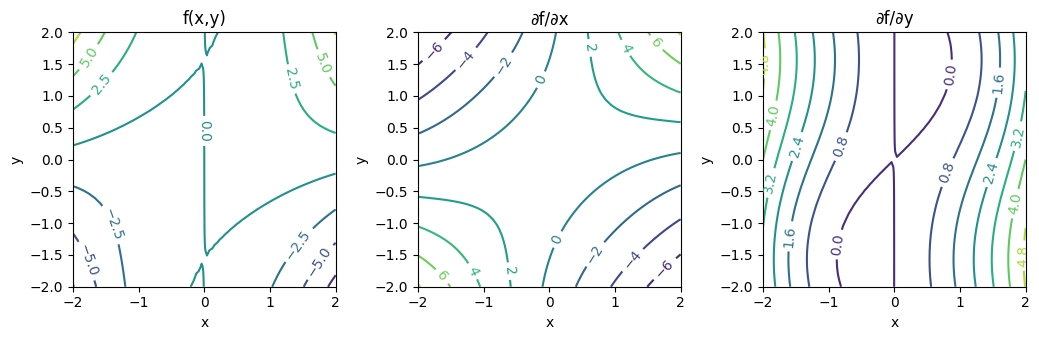

In [26]:
def f(x, y):
    """Example multivariate function: sin(x)cos(y) + x²y."""
    if isinstance(x, df.Dual) and isinstance(y, df.Dual):
        return df.Dual.sin(x) * df.Dual.cos(y) + x**2 * y
    elif isinstance(x, df.Dual):
        return df.Dual.sin(x) * np.cos(y) + x**2 * y
    elif isinstance(y, df.Dual):
        return np.sin(x) * df.Dual.cos(y) + x**2 * y
    return np.sin(x) * np.cos(y) + x**2 * y

# Create grid of points
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)

# Compute function values
Z = np.array([[f(xi, yi) for xi in x] for yi in y])

# Compute partial derivatives
dfdx = np.array([[f(df.Dual(xi, 1.0), yi).dual for xi in x] for yi in y])
dfdy = np.array([[f(xi, df.Dual(yi, 1.0)).dual for xi in x] for yi in y])

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(10.5, 3.5))

# Function values
c1 = axes[0].contour(X, Y, Z)
axes[0].clabel(c1)
axes[0].set_title('f(x,y)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Partial derivative with respect to x
c2 = axes[1].contour(X, Y, dfdx)
axes[1].clabel(c2)
axes[1].set_title('∂f/∂x')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

# Partial derivative with respect to y
c3 = axes[2].contour(X, Y, dfdy)
axes[2].clabel(c3)
axes[2].set_title('∂f/∂y')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')

plt.tight_layout()
plt.show()

We can also compute the relative error between the partial derivatives and the actual derivatives.

Analytically, we have:

$$\frac{\partial f}{\partial x} = \cos(x)\cos(y) + 2xy$$

$$\frac{\partial f}{\partial y} = -\sin(x)\sin(y) + x²$$

Let's compute the relative error between the partial derivatives and the actual derivatives.

In [27]:
# Define analytical partial derivatives
def dfdx_analytical(x, y):
    """Analytical partial derivative with respect to x"""
    return np.cos(x) * np.cos(y) + 2 * x * y

def dfdy_analytical(x, y):
    """Analytical partial derivative with respect to y"""
    return -np.sin(x) * np.sin(y) + x**2

# Compute analytical derivatives on the grid
dfdx_true = np.array([[dfdx_analytical(xi, yi) for xi in x] for yi in y])
dfdy_true = np.array([[dfdy_analytical(xi, yi) for xi in x] for yi in y])

# Compute relative errors
# Add small epsilon to avoid division by zero
epsilon = 1e-10
rel_error_x = np.abs((dfdx - dfdx_true) / (np.abs(dfdx_true) + epsilon))
rel_error_y = np.abs((dfdy - dfdy_true) / (np.abs(dfdy_true) + epsilon))

# Print maximum relative errors
print(f"Maximum relative error in ∂f/∂x: {np.max(rel_error_x):.2e}")
print(f"Maximum relative error in ∂f/∂y: {np.max(rel_error_y):.2e}")

Maximum relative error in ∂f/∂x: 0.00e+00
Maximum relative error in ∂f/∂y: 0.00e+00


It seems that the relative error is really low, which is good!

## 2. Gradient

Gradient is a vector of partial derivatives of a function, it is a fundamental concept in optimization.

$$\nabla f(x) = \begin{bmatrix} 
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}$$

We have seen how to compute partial derivatives using dual numbers. Now let's implement a function to compute the gradient.


In [28]:
def gradient(f, x):
    """Compute gradient of f at point x"""
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        x_dual = [Dual(x[j], 1.0 if j==i else 0.0) for j in range(n)]
        grad[i] = f(*x_dual).dual
    return grad

For example, let's compute the gradient of the function $f(x,y) = (1-x)² + (y-x²)²$ at the point $(2,1)$ and $(1,1)$.

In [29]:
def f(x, y):
    """Bowl-shaped function: f(x,y) = (1-x)² + (y-x²)²
    Global minimum at (1,1)"""
    if isinstance(x, Dual):
        return (1-x)**2 + (y-x**2)**2
    elif isinstance(y, Dual):
        return (1-x)**2 + (y-x**2)**2
    return (1-x)**2 + (y-x**2)**2

x = np.array([2.0, 1.0])
print(gradient(f, x))
x = np.array([1.0, 1.0])
print(gradient(f, x))

[26. -6.]
[-0.  0.]


And we can try to use this gradient to find the minimum of the function.

In the simple example above, we can use gradient descent to find the minimum of the function, which is obviously at $(1,1)$ with value $0$.


Starting from [2. 2.]: Found minimum at [1.1193648  1.29844946] with value 0.016316
Starting from [-1.5  1.5]: Found minimum at [0.94026418 0.85822672] with value 0.004238
Starting from [ 1.5 -1.5]: Found minimum at [0.92565609 0.82428023] with value 0.006587
Starting from [-2. -2.]: Found minimum at [0.91919662 0.80935739] with value 0.007794


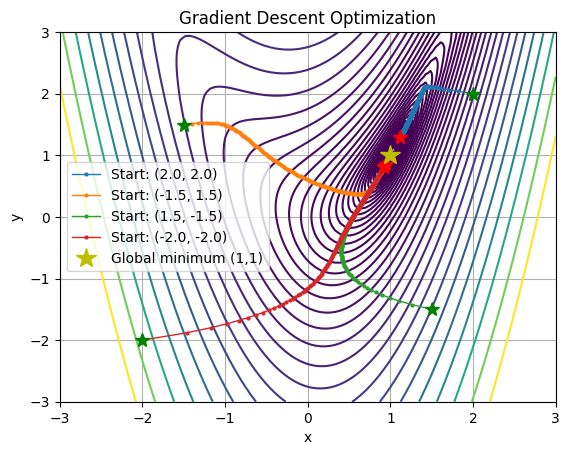

In [30]:
def gradient_descent(f, x0, learning_rate=0.01, n_iterations=500, tolerance=1e-6):
    """Gradient descent optimization.
    
    Args:
        f: Function to minimize
        x0: Initial point (numpy array)
        learning_rate: Learning rate for gradient descent
        n_iterations: Maximum number of iterations
        tolerance: Convergence tolerance
        
    Returns:
        x_history: History of points visited
        f_history: History of function values
    """
    x = x0.copy()
    x_history = [x.copy()]
    f_history = [f(*x)]
    
    for i in range(n_iterations):
        grad = gradient(f, x)
        if np.linalg.norm(grad) < tolerance:
            break
            
        x = x - learning_rate * grad
        x_history.append(x.copy())
        f_history.append(f(*x))
    
    return np.array(x_history), np.array(f_history)

# Create grid of points for contour plot
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([[f(xi, yi) for xi in x] for yi in y])

# Run gradient descent from different starting points
starting_points = [
    np.array([2.0, 2.0]),
    np.array([-1.5, 1.5]),
    np.array([1.5, -1.5]),
    np.array([-2.0, -2.0])
]

plt.figure()

# Plot contours of the function
plt.contour(X, Y, Z, levels=np.logspace(-3.5, 1.8, 50))

# Run gradient descent from each starting point
for x0 in starting_points:
    x_history, f_history = gradient_descent(f, x0)
    
    # Plot optimization path
    plt.plot(x_history[:, 0], x_history[:, 1], 'o-', linewidth=1, markersize=2, 
             label=f'Start: ({x0[0]}, {x0[1]})')
    
    # Plot start and end points
    plt.plot(x_history[0, 0], x_history[0, 1], 'g*', markersize=10)
    plt.plot(x_history[-1, 0], x_history[-1, 1], 'r*', markersize=10)

    print(f"Starting from {x0}: Found minimum at {x_history[-1]} with value {f_history[-1]:.6f}")

plt.plot(1, 1, 'y*', markersize=15, label='Global minimum (1,1)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient Descent Optimization')
plt.legend()
plt.grid(True)
plt.show()

## 3. A bit on Higher Derivatives

Dual numbers are typically used to compute first derivatives. 

To compute higher derivatives, we may need to extend the dual number class, or use other methods.

Higher derivatives now can be computed combined with numerical differentiation:

In [31]:
def second_derivative(f, x, h=1e-8):
    """Compute second derivative using a combination of dual numbers and finite differences.
    
    Args:
        f: Function to differentiate
        x: Point at which to evaluate derivative
        h: Small step size for finite differences
    
    Returns:
        Second derivative value
    """
    # First forward pass - compute df/dx
    def df(x):
        return f(Dual(x, 1.0)).dual
    
    # Second forward pass - compute d²f/dx²
    return (df(x + h) - df(x)) / h

Let's compute the second derivative of $f(x) = \sin(x)$ and plot it.

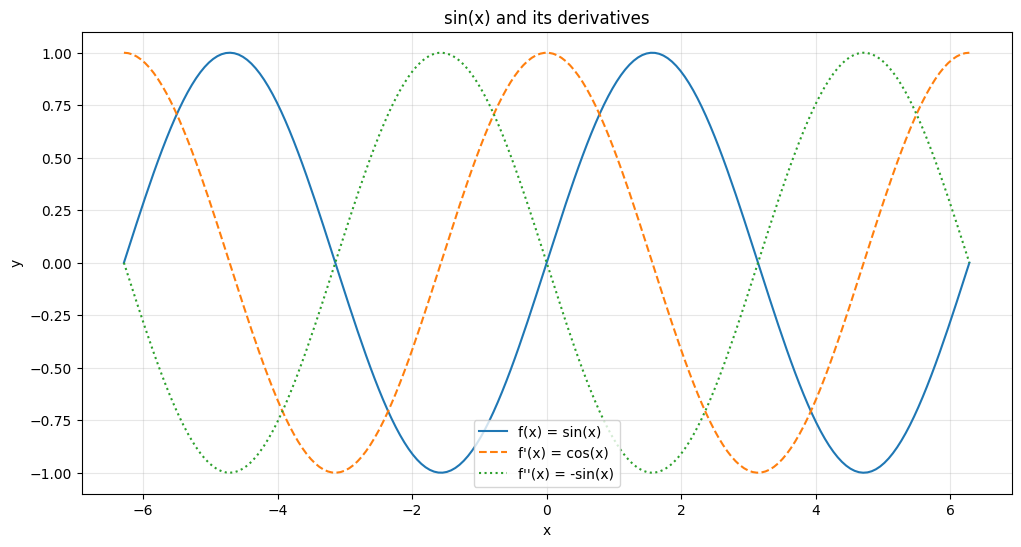

At x = π/4:
f(x) = sin(x) = 0.707107
f'(x) = cos(x) = 0.707107
f''(x) = -sin(x) = -0.707107


In [32]:
def f(x):
    if isinstance(x, Dual):
        return Dual.sin(x)
    return np.sin(x)

# Create points for plotting
x = np.linspace(-2*np.pi, 2*np.pi, 200)

# Compute function values
y = np.array([f(xi) for xi in x])

# Compute first derivatives using dual numbers
dydx = np.array([f(Dual(xi, 1.0)).dual for xi in x])

# Compute second derivatives using the second_derivative function
d2ydx2 = np.array([second_derivative(f, xi) for xi in x])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='f(x) = sin(x)')
plt.plot(x, dydx, '--', label="f'(x) = cos(x)")
plt.plot(x, d2ydx2, ':', label="f''(x) = -sin(x)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('sin(x) and its derivatives')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Print some values to verify correctness
x0 = np.pi/4
print(f"At x = π/4:")
print(f"f(x) = sin(x) = {np.sin(x0):.6f}")
print(f"f'(x) = cos(x) = {np.cos(x0):.6f}")
print(f"f''(x) = -sin(x) = {-np.sin(x0):.6f}")